In [476]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split , StratifiedKFold
import numpy as np
import cv2
import os
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout,ReLU
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix

In [477]:
df = pd.read_csv('Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [478]:
tabular_data = df.drop(['id' , 'label'] , axis=1)
labels = df['label']

In [479]:
# Scaler = StandardScaler()
# Scaled_tabular_data = Scaler.fit_transform(tabular_data)

In [480]:
image_folder = r"C:\Users\User\Desktop\Junior\Machine\Machine Project\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"
image_list = []

for image_id in df['id']:
    img_name = f"{int(image_id):04d}.jpg"
    

    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Image not found: {img_path}")
        continue

    img = img/255.0

    img= img[..., np.newaxis]
    image_list.append(img)

x_img = np.array(image_list, dtype=np.float32)
print(f"Image data shape: {x_img.shape}")


Image data shape: (128, 256, 256, 1)


In [482]:
X_tab_trainval, X_tab_test, X_img_trainval, X_img_test, y_trainval, y_test = train_test_split(
    tabular_data, x_img, labels, test_size=0.3, stratify=labels, random_state=42
)

In [483]:
image_input = Input(shape=(256, 256, 1))

x = RandomFlip("horizontal")(image_input)
x = RandomRotation(0.2)(x)
x = RandomZoom(0.2)(x)

x = Conv2D(32, (3,3), kernel_regularizer=l2(1e-3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), kernel_regularizer=l2(1e-3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D((2,2))(x)


x = Conv2D(128, (3,3), kernel_regularizer=l2(1e-3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)


x = GlobalAveragePooling2D()(x)

x = Dense(64 , kernel_regularizer=l2(1e-3), activation='relu' , name="cnn_features")(x)
x = Dropout(0.3)(x)

cnn_feature_extractor = Model(inputs=image_input, outputs=x)
cnn_feature_extractor.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_32 (RandomFlip)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_32              │ (None, 256, 256, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_32 (RandomZoom)     │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_96 (ReLU)                 │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_97 (ReLU)                 │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_98 (ReLU)                 │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_32     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_features (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,824 (397.75 KB)

 Trainable params: 101,376 (396.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [484]:
# Extract features for all images
cnn_features = cnn_feature_extractor.predict(x_img) 
print(f"CNN features shape: {cnn_features.shape}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
CNN features shape: (128, 64)


In [485]:
X_combined = np.concatenate([tabular_data, cnn_features], axis=1)
print(f"Combined features shape: {X_combined.shape}") 


Combined features shape: (128, 464)


In [ ]:
# Lists to store results for each fold
cv_train_acc = []
cv_val_acc = []
cv_val_auc = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_tab_trainval, y_trainval), 1):

    print(f"\n===== Fold {fold} =====")

   
    X_tab_train = X_tab_trainval.iloc[train_idx]
    X_tab_val   = X_tab_trainval.iloc[val_idx]

    X_img_train = X_img_trainval[train_idx]
    X_img_val   = X_img_trainval[val_idx]

    y_train = y_trainval.iloc[train_idx]
    y_val   = y_trainval.iloc[val_idx]

    
    tab_scaler = StandardScaler()
    X_tab_train = tab_scaler.fit_transform(X_tab_train)
    X_tab_val   = tab_scaler.transform(X_tab_val)

    
    train_cnn = cnn_feature_extractor.predict(X_img_train)
    val_cnn   = cnn_feature_extractor.predict(X_img_val)

 
    X_train_comb = np.concatenate([X_tab_train, train_cnn], axis=1)
    X_val_comb   = np.concatenate([X_tab_val, val_cnn], axis=1)

   
    comb_scaler = StandardScaler()
    X_train_scaled = comb_scaler.fit_transform(X_train_comb)
    X_val_scaled   = comb_scaler.transform(X_val_comb)

  
    svm = SVC(kernel='rbf', C=1, gamma=0.001)
    svm.fit(X_train_scaled, y_train)

    
    train_pred = svm.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, train_pred)
    cv_train_acc.append(train_acc)

  
    val_pred = svm.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    cv_val_acc.append(val_acc)

    val_scores = svm.decision_function(X_val_scaled)
    fpr, tpr, _ = roc_curve(y_val, val_scores)
    val_auc = auc(fpr, tpr)
    cv_val_auc.append(val_auc)

    print(f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | Val ROC-AUC: {val_auc:.3f}")

# Final Cross-Validation Summary
print("\n" + "="*25)
print(f"Mean CV Train Accuracy: {np.mean(cv_train_acc):.3f}")
print(f"Mean CV Val Accuracy:   {np.mean(cv_val_acc):.3f}")
print(f"Mean CV Val ROC-AUC:    {np.mean(cv_val_auc):.3f}")


===== Fold 1 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Train Acc: 0.676 | Val Acc: 0.667 | Val ROC-AUC: 0.901

===== Fold 2 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Train Acc: 0.704 | Val Acc: 0.611 | Val ROC-AUC: 0.679

===== Fold 3 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Train Acc: 0.789 | Val Acc: 0.556 | Val ROC-AUC: 0.525

===== Fold 4 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Train Acc: 0.789 | Val Acc: 0.778 | Val ROC-AUC: 0.775

===== Fold 5 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Train Acc: 0.722 | Val Acc: 0.647 | Val ROC-AUC: 0.597

Mean CV Train Accuracy: 0.736
Mean CV Val Accuracy:   0.652
Mean CV Val ROC-AUC:    0.695


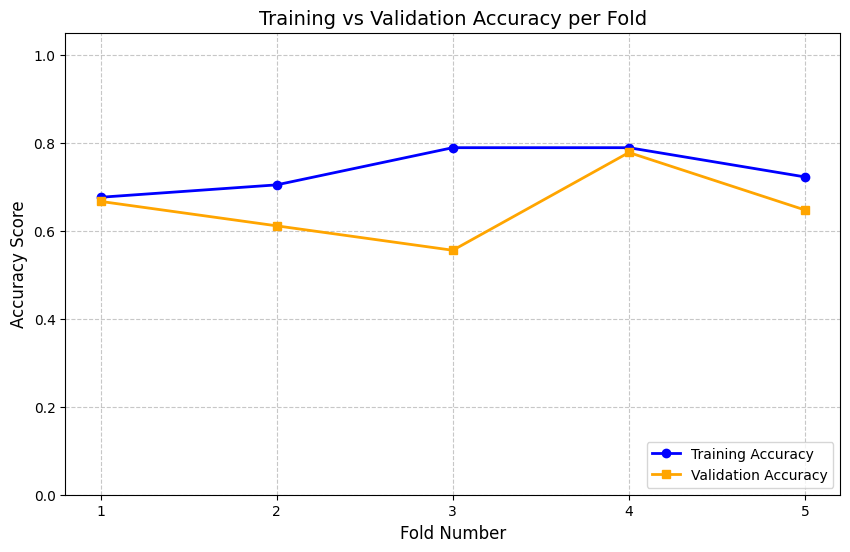

In [ ]:
import matplotlib.pyplot as plt


folds = range(1, len(cv_train_acc) + 1)

plt.figure(figsize=(10, 6))


plt.plot(folds, cv_train_acc, 'o-', label='Training Accuracy', color='blue', linewidth=2)


plt.plot(folds, cv_val_acc, 's-', label='Validation Accuracy', color='orange', linewidth=2)


plt.title('Training vs Validation Accuracy per Fold', fontsize=14)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xticks(folds) 
plt.ylim(0, 1.05) 
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')



In [ ]:

tab_scaler = StandardScaler()
X_tab_trainval_scaled = tab_scaler.fit_transform(X_tab_trainval)
X_tab_test_scaled     = tab_scaler.transform(X_tab_test)


trainval_cnn = cnn_feature_extractor.predict(X_img_trainval)
test_cnn     = cnn_feature_extractor.predict(X_img_test)


X_trainval_comb = np.concatenate([X_tab_trainval_scaled, trainval_cnn], axis=1)
X_test_comb     = np.concatenate([X_tab_test_scaled, test_cnn], axis=1)


comb_scaler = StandardScaler()
X_trainval_scaled = comb_scaler.fit_transform(X_trainval_comb)
X_test_scaled     = comb_scaler.transform(X_test_comb)


svm = SVC(kernel='rbf', C=1, gamma=0.001)
svm.fit(X_trainval_scaled, y_trainval)

test_pred = svm.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_pred)

test_scores = svm.decision_function(X_test_scaled)
fpr_test, tpr_test, _ = roc_curve(y_test, test_scores)
test_auc = auc(fpr_test, tpr_test)

print("\nFinal Test Accuracy:", test_acc)
print("Final Test ROC-AUC:", test_auc)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 

Final Test Accuracy: 0.7435897435897436
Final Test ROC-AUC: 0.783068783068783


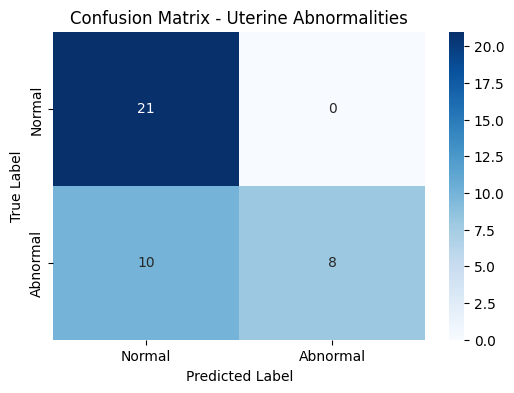

              precision    recall  f1-score   support

      Normal       0.68      1.00      0.81        21
    Abnormal       1.00      0.44      0.62        18

    accuracy                           0.74        39
   macro avg       0.84      0.72      0.71        39
weighted avg       0.83      0.74      0.72        39



In [475]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' ,xticklabels=["Normal", "Abnormal"],
   yticklabels=["Normal", "Abnormal"])
plt.title("Confusion Matrix - Uterine Abnormalities")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

target_names =['Normal' , 'Abnormal']
print(classification_report(y_test, test_pred , target_names=target_names))